## Example of using TorchCNNBuilder for MovingMnist dataset

#### MovingMnist dataset is benchmark for video forecasting task. It is presented by 1000 samples with 20 frames series with numbers which are moving on different trajectories. It can be loaded by [official link](https://www.cs.toronto.edu/~nitish/unsupervised_video/).

In [7]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn, optim, tensor
from torch.utils.data import TensorDataset, DataLoader
from torchcnnbuilder.models import ForecasterBase
from torch.optim.lr_scheduler import ReduceLROnPlateau

##### Data preparation include normalization and separating on train and test parts. As features (input) for model first 15 frames are used, as target (output) last 5 frames are used.

It should be noticed, that there is not cyclic component in each time-spatial series. So model should learn dynamics of numbers moving by examples from other series (on other numbers). And convolutional layers should help to reproduce view of number by previous frames of series. 

In [33]:
data = np.load('data/moving_mnist.npy').astype(np.float32)/255

train_set = data[:, :8000, :, :]
test_set = data[:, 8000:, :, :]

train_features = train_set[:15, :, :, :]
train_features = np.swapaxes(train_features, 0, 1)
train_target = train_set[15:, :, :, :]
train_target = np.swapaxes(train_target, 0, 1)

train_dataset = TensorDataset(tensor(train_features), tensor(train_target))

##### Model building with simple structure - 5 convolutional and transposed convolutional layers

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = ForecasterBase(input_size=[64, 64],
                       in_channels=15,
                       out_channels=5,
                       n_layers=5)
model = model.to(device)

cuda


##### Training parameters set

In [35]:
epochs = 1000
batch_size = 100
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()

##### Training model 

In [36]:
from tqdm.notebook import tqdm

progress_bar = tqdm(list(np.arange(epochs)), desc="Epoch", colour="white")
info_bar = {"Loss": 0}
losses = []
epoches = []
for epoch in range(epochs):
    loss = 0
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)

        optimizer.zero_grad()
        outputs = model(train_features)

        train_loss = criterion(outputs, test_features)

        train_loss.backward()
        optimizer.step()

        loss += train_loss.item()

    loss = loss / len(dataloader)
    
    info_bar['Loss'] = np.round(loss, 5)
    progress_bar.update()
    progress_bar.set_postfix_str(info_bar)

    losses.append(loss)
    epoches.append(epoch)

torch.save(model.state_dict(), f'mnist_{epochs}.pt')

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

C:\Users\Julia\AppData\Local\Temp\ipykernel_12880\313545494.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


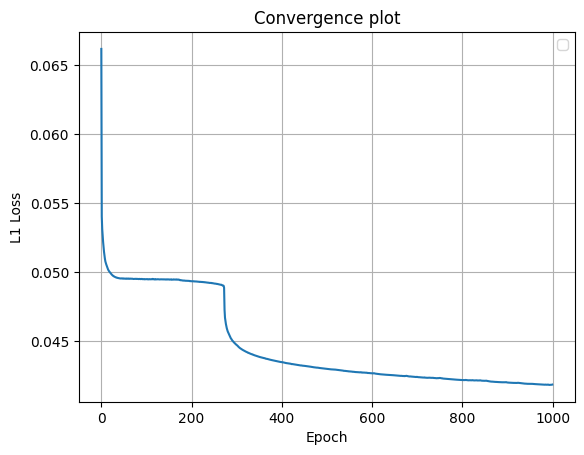

In [37]:
plt.plot(epoches, losses)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.title('Convergence plot')
plt.show()

Data loaded


C:\Users\Julia\AppData\Local\Temp\ipykernel_12880\2918040862.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


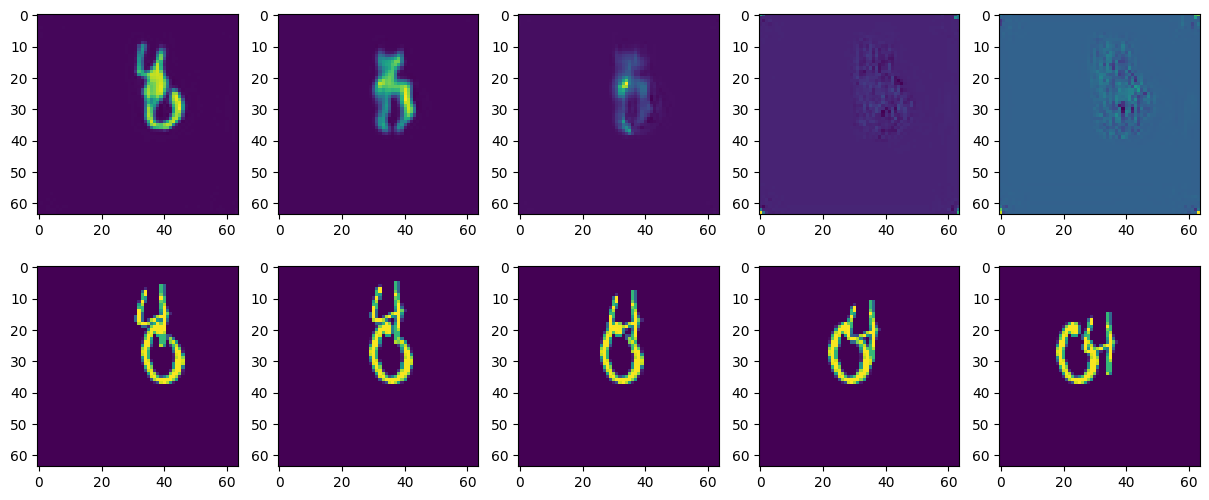

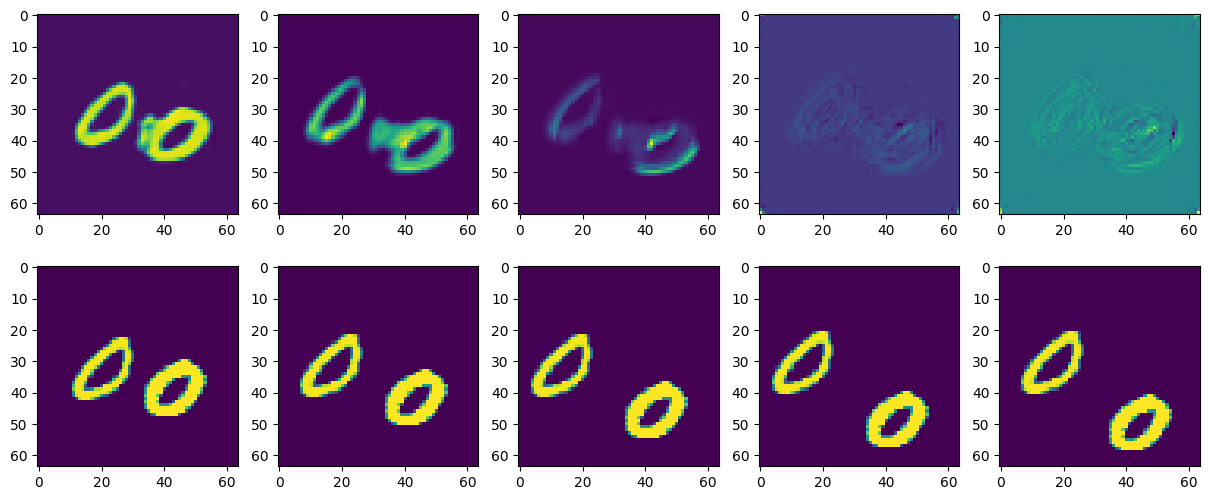

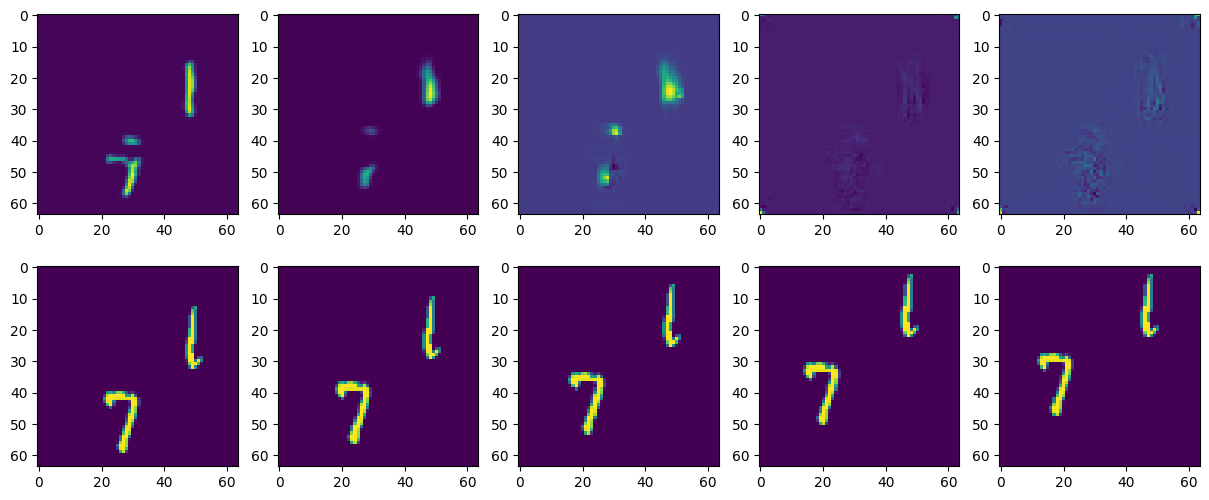

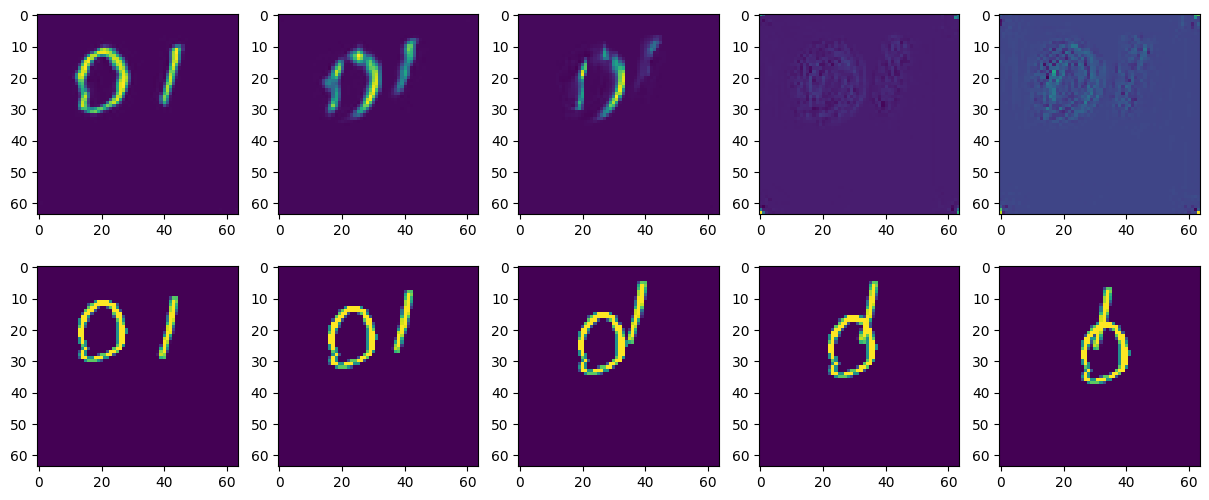

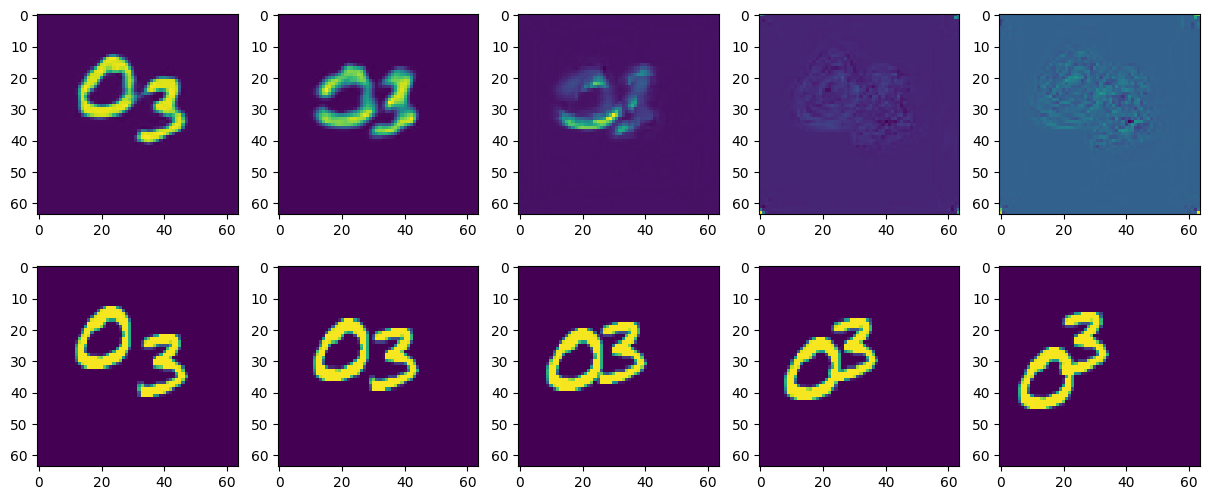

In [41]:
test_features = test_set[:15, :, :, :]
test_features = np.swapaxes(test_features, 0, 1)
test_target = test_set[15:, :, :, :]
test_target = np.swapaxes(test_target, 0, 1)
print('Data loaded')

for s in range(5):
    tensor_features = tensor(test_features[s]).to(device)
    prediction = model(tensor_features).detach().cpu().numpy()
    plt.rcParams["figure.figsize"] = (15, 6)
    fig, axs = plt.subplots(2, 5)
    for i in range(5):
        axs[0][i].imshow(prediction[i])
        axs[1][i].imshow(test_target[s][i])
    fig.show()

In [43]:
model3d = ForecasterBase(input_size=[64, 64, 64],
                              in_channels=1,
                              out_channels=5,
                              n_layers=5,
                              conv_dim=3)
model3d = model3d.to(device)

In [44]:
progress_bar = tqdm(list(np.arange(epochs)), desc="Epoch", colour="white")
info_bar = {"Loss": 0}
losses = []
epoches = []
for epoch in range(epochs):
    loss = 0
    for train_features, test_features in dataloader:
        train_features = train_features.to(device)
        test_features = test_features.to(device)

        optimizer.zero_grad()
        outputs = model3d(train_features)

        train_loss = criterion(outputs, test_features)

        train_loss.backward()
        optimizer.step()

        loss += train_loss.item()

    loss = loss / len(dataloader)
    
    info_bar['Loss'] = np.round(loss, 5)
    progress_bar.update()
    progress_bar.set_postfix_str(info_bar)

    losses.append(loss)
    epoches.append(epoch)

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [2, 1, 3, 3, 3], expected input[1, 100, 15, 64, 64] to have 1 channels, but got 100 channels instead